In [1]:
import sys
import glob
import math as mth
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

from astropy.utils.data import download_file
from ligo.gracedb.rest import GraceDb
from ligo.skymap.io.fits import read_sky_map

### Simulate Injections

In [2]:
#np.random.seed(0)

In [3]:
sys.stdout = open('output_log.txt','wt')

In [4]:
def num_above(array, minfar=10**(-9), maxfar=10**(-3)):
    
    powers = np.arange(mag(minfar),mag(maxfar), .01)
    bins = 10.**powers
    
    digi = np.digitize(array, bins, right=True)
    val, counts = np.unique(digi, return_counts=True)

    return np.array(bins)[val], np.cumsum(counts)

def calc_overlap(grb_skymap, lvc_skymap):
    return len(grb_skymap)*grb_skymap.dot(lvc_skymap)/grb_skymap.sum()/lvc_skymap.sum()

def rand_skymap(skymap_array):
    ind = mth.floor(np.random.random() * len(skymap_array))
    return skymap_array[ind]

def mag(x):
    return int(mth.log10(x))

In [5]:
# Get GRB skymap
print('Loading GRB sky maps.....')
grb_skymap_fnames = glob.glob('data/grb/*')
grb_skymaps = []
for fname in grb_skymap_fnames:
    grb_skymaps.append(hp.read_map(fname, verbose=False))

# Get LVC skymap
print('Loading LVC sky maps.....')
lvc_skymaps_fnames = glob.glob('data/gstlal/*')
lvc_skymaps_fnames += glob.glob('data/pycbc/*')
lvc_skymaps = []
for fname in lvc_skymaps_fnames:
    lvc_skymaps.append(hp.read_map(fname, verbose=False))

In [6]:
print('Number of GRB sky maps: '+str(len(grb_skymaps)))
print('Number of LVC sky maps: '+str(len(lvc_skymaps)))

In [7]:
#tot_overlap = 0
#for i in range(107):
#    spat_overlap = calc_overlap(grb_skymaps[i], lvc_skymaps[i])
#    tot_overlap += spat_overlap
    
#print(tot_overlap/107)

In [8]:
years = 25
sec_per_year = 86400 * 365

far_thresh = 1 / 3600
number_of_pipelines = 4

OPA_far_thresh = 6 / (sec_per_year)
n_grb0 = 547 # per year
gw_rate = 12 / sec_per_year
grb_rate = n_grb0 / sec_per_year
n_grb =  int(n_grb0 * years) # total
n_gw = int(far_thresh * sec_per_year * years * number_of_pipelines) # total
far_gw = np.random.power(1, n_gw) * far_thresh # create FAR for each event

th = -1 # start window
tl = 5 # end window

print('Simulating '+str(years)+' years')
print('Number of GRBs: ' +str(int(n_grb)))
print('Number of GWs: ' +str(int(n_gw)))
print('Using ['+str(th)+','+str(tl)+'] window')

In [9]:
# create random time for each event
t_grb = np.random.random(n_grb) * sec_per_year * years
t_gw = np.random.random(n_gw) * sec_per_year * years

In [10]:
#predict number of coincidences
n_err = n_gw * grb_rate * (tl-th)

print('Expected number of false coincidence events: ' +str(int(n_err)))

In [13]:
# look for coincidences
num = 0
i = 0
far_c = []
far_c_spat =[]
print('Looking for coincidences...')
t_start = timeit.default_timer()
for gw in t_gw:
    num_add = np.sum((gw - t_grb > th) & (gw - t_grb < tl))
    num += num_add
    if num_add:
        bayes_gw = 1/far_gw[i] #10**5*abs(np.random.normal(1, 1))
        coinc_far = far_gw[i] * grb_rate * (1 + far_thresh / bayes_gw / gw_rate) * (tl-th) 
        spat_int = calc_overlap(rand_skymap(grb_skymaps), rand_skymap(lvc_skymaps))
        far_c.append(coinc_far)
        far_c_spat.append(coinc_far/spat_int)
    i += 1
t_end = timeit.default_timer()
print('Number of found coincidences: ' +str(int(num)))
print('Took '+str((t_end - t_start)/60)+' minutes')
print('Min/Max space-time coincidence FAR (Hz): ' +str(min(far_c_spat))+' / '+str(max(far_c_spat)))

### Check Coinc FAR

In [14]:
# count number above each FAR
coinc_FAR_used, coinc_counts = num_above(far_c, minfar=min(far_c)/100, maxfar=10**(-1))
coinc_FAR_spat_used, coinc_spat_counts = num_above(far_c_spat, minfar=min(far_c_spat)/100, maxfar=max(far_c_spat)*100)
gw_FAR_used, gw_counts = num_above(far_gw, minfar=min(far_gw)/10, maxfar=10**(-2))
total_FAR_used, total_counts = num_above(np.concatenate((far_gw, np.array(far_c) * number_of_pipelines)), minfar=min(far_gw)/10, maxfar=10**(-1))
total_FAR_spat_used, total_spat_counts = num_above(np.concatenate((far_gw, np.array(far_c_spat) * number_of_pipelines)), minfar=min(far_c_spat)/10, maxfar=max(far_c_spat)*100)

# Apply trials factors
coinc_FAR_used *= number_of_pipelines
coinc_FAR_spat_used *= number_of_pipelines
gw_FAR_used *= number_of_pipelines
total_FAR_used *= 1

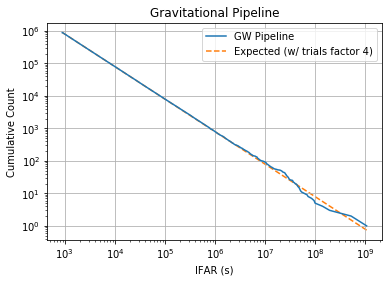

In [15]:
# plot gravitational FAR

plt.plot(1/gw_FAR_used, gw_counts, zorder=2, label='GW Pipeline')
plt.plot(1/gw_FAR_used, (gw_FAR_used * sec_per_year * years), '--', zorder=1, label='Expected (w/ trials factor '+str(number_of_pipelines)+')')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
plt.title('Gravitational Pipeline')
plt.legend(loc='best')
plt.grid()
plt.savefig('Gravitational_far.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

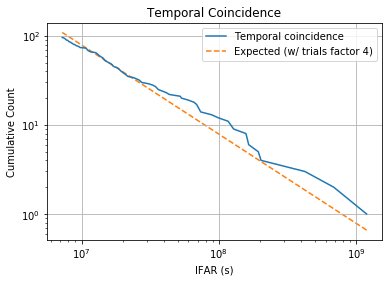

In [16]:
# plot coinc FAR

plt.plot(1/coinc_FAR_used, coinc_counts, zorder=3, label='Temporal coincidence')
#plt.plot(1/gw_FAR_used , gw_counts, zorder=2, label='GW FAR Set')
plt.plot(1/coinc_FAR_used , (coinc_FAR_used * sec_per_year * years), '--',zorder=1, label='Expected (w/ trials factor '+str(number_of_pipelines)+')')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
plt.title('Temporal Coincidence')
plt.legend(loc='best')
plt.grid()
plt.savefig('Coincidence_far.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

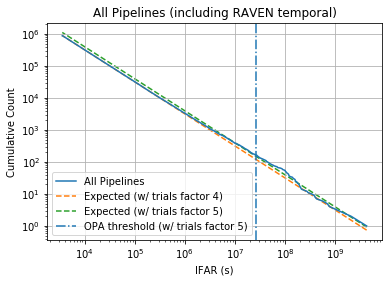

In [17]:
plt.plot(1/total_FAR_used , total_counts, zorder=3, label='All Pipelines')
#plt.plot(1/gw_FAR_used , gw_counts, zorder=2, label='GW FAR Set')
plt.plot(1/total_FAR_used, (total_FAR_used * sec_per_year * years * (number_of_pipelines)), '--',zorder=1, label='Expected (w/ trials factor '+str(number_of_pipelines)+')')
plt.plot(1/total_FAR_used, (total_FAR_used * sec_per_year * years * (number_of_pipelines +1)), '--',zorder=1, label='Expected (w/ trials factor '+str(number_of_pipelines+1)+')')
plt.axvline(x=1/(OPA_far_thresh) * (number_of_pipelines+1), linestyle='-.', label='OPA threshold (w/ trials factor '+str(number_of_pipelines+1)+')')
#plt.axvline(x=1/(OPA_far_thresh), linestyle='-.', color='r', label='OPA threshold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
plt.title('All Pipelines (including RAVEN temporal)')
plt.legend(loc='best')
plt.grid()
plt.savefig('Total_far.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

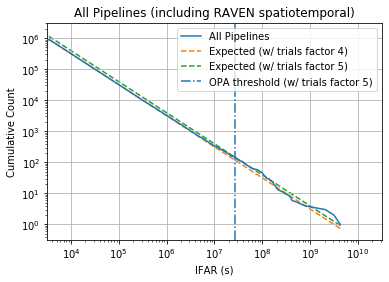

In [18]:
plt.plot(1/total_FAR_spat_used , total_spat_counts, zorder=3, label='All Pipelines')
#plt.plot(1/gw_FAR_used , gw_counts, zorder=2, label='GW FAR Set')
plt.plot(1/total_FAR_spat_used, (total_FAR_spat_used * sec_per_year * years * (number_of_pipelines)), '--',zorder=1, label='Expected (w/ trials factor '+str(number_of_pipelines)+')')
plt.plot(1/total_FAR_spat_used, (total_FAR_spat_used * sec_per_year * years * (number_of_pipelines +1)), '--',zorder=1, label='Expected (w/ trials factor '+str(number_of_pipelines+1)+')')
plt.axvline(x=1/(OPA_far_thresh) * (number_of_pipelines+1), linestyle='-.', label='OPA threshold (w/ trials factor '+str(number_of_pipelines+1)+')')
#plt.axvline(x=1/(OPA_far_thresh), linestyle='-.', color='r', label='OPA threshold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
plt.xlim(10**(3.5),10**(10.5))
plt.ylim(10**(-.5),10**(6.5))
plt.title('All Pipelines (including RAVEN spatiotemporal)')
plt.legend(loc='best')
plt.grid()
plt.savefig('Total_spat_far.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

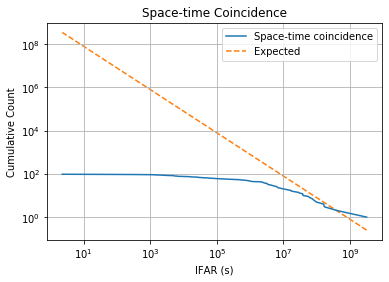

In [19]:
# plot space-time coinc FAR

plt.plot(1/coinc_FAR_spat_used , coinc_spat_counts, zorder=3, label='Space-time coincidence')
#plt.plot(1/gw_FAR_used , gw_counts, zorder=2, label='GW FAR Set')
plt.plot(1/coinc_FAR_spat_used, (coinc_FAR_spat_used * sec_per_year * years), '--',zorder=1, label='Expected')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
plt.title('Space-time Coincidence')
plt.legend(loc='best')
plt.grid()
plt.savefig('Coincidence_spat_far.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

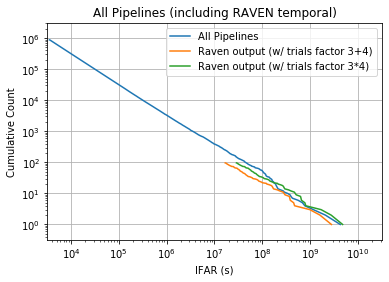

In [20]:
plt.plot(1/total_FAR_used , total_counts, zorder=3, label='All Pipelines')
plt.plot(1/(coinc_FAR_used*3)*7, coinc_counts, zorder=3, label='Raven output (w/ trials factor 3+4)')
plt.plot(1/(coinc_FAR_used*3)*12, coinc_counts, zorder=3, label='Raven output (w/ trials factor 3*4)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
plt.xlim(10**(3.5),10**(10.5))
plt.ylim(10**(-.5),10**(6.5))
plt.title('All Pipelines (including RAVEN temporal)')
plt.legend(loc='best')
plt.grid()
plt.savefig('RAVEN_trials_factor_measurement.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

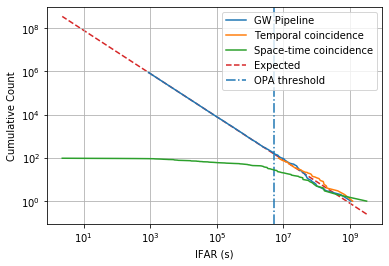

In [21]:
plt.plot(1/gw_FAR_used , gw_counts, zorder=2, label='GW Pipeline')
plt.plot(1/coinc_FAR_used , coinc_counts, zorder=3, label='Temporal coincidence')
plt.plot(1/coinc_FAR_spat_used , coinc_spat_counts, zorder=4, label='Space-time coincidence')

max_far = np.amax(np.concatenate([gw_FAR_used, coinc_FAR_used, coinc_FAR_spat_used]))
min_far = np.amin(np.concatenate([gw_FAR_used, coinc_FAR_used, coinc_FAR_spat_used]))
far_range = np.array([min_far,max_far])

plt.plot(1/far_range, (far_range * sec_per_year * years), '--',zorder=1, label='Expected')
plt.axvline(x=1/OPA_far_thresh, linestyle='-.', label='OPA threshold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (s)')
plt.ylabel('Cumulative Count')
#plt.title('Space-time Coincidence')
plt.legend(loc='best')
plt.grid()
plt.savefig('all_far.png', bbox_inches='tight', dpi=125)
plt.show()
plt.close()

In [22]:
num_thresh = int(OPA_far_thresh * years * sec_per_year)
num_temp = np.sum(np.array(far_c) < OPA_far_thresh)
num_spacetime = np.sum(np.array(far_c_spat) < OPA_far_thresh)

print('Expected number pass threshold: '+str(num_thresh*number_of_pipelines))
print('Number of temporal coincidences pass threshold: '+str(num_temp))
print('Number of space-time coincidences pass threshold: '+str(num_spacetime))

In [23]:
#! jupyter nbconvert trials_factor_study.ipynb --to script